In [3]:
import pickle
from pathlib import Path
import os
import numpy as np
from itertools import chain
from nilearn import datasets
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import xarray as xr
import significantdigits as sd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap 
import scipy.stats



### Seed Connectivity

In [62]:
seed_connectivity = pickle.load(open('subject_matrices.pkl', 'rb'))

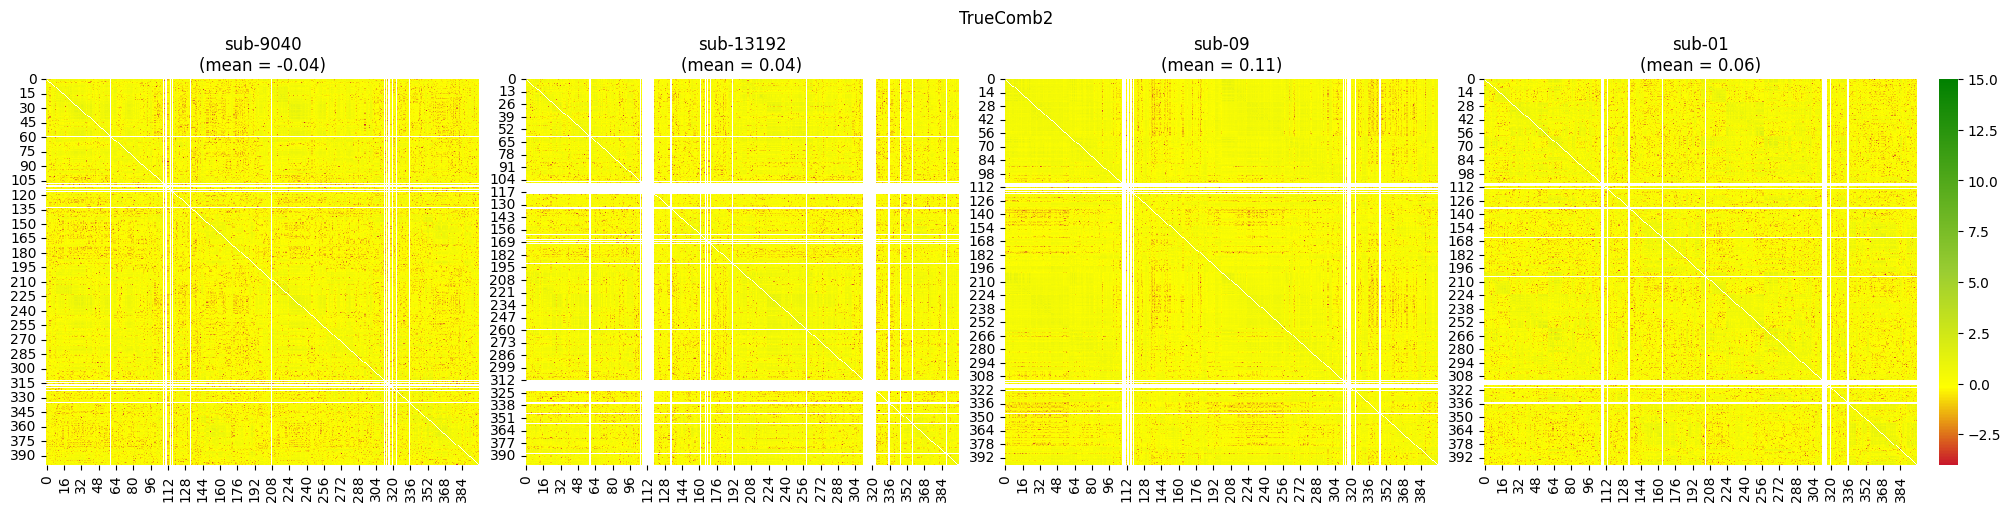

In [82]:
colors = ["#C9182B","yellow","yellowgreen","green"]
values = np.array([0, 0.2, 0.5, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))


for pre_process in seed_connectivity['sub-9040'].keys():
    fig, axes = plt.subplots(ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True)

    for num, sub in enumerate(seed_connectivity.keys()):
        input = np.array(seed_connectivity[sub][pre_process])
        # mask = ~np.isnan(input).any(axis=(1, 2))
        # input[mask] = -np.inf
        sigdigs = sd.significant_digits(input, reference=input.mean(axis=0), basis=10)
        # sigdigs[np.isclose(sigdigs, 15.214328120692226, rtol=1e-4)] = np.nan
        sigdigs[sigdigs >= 15] = np.nan #temporary fix to sigdigs not dealing with NaN

        if num != 3: sns.heatmap(sigdigs, cmap=cmap, ax=axes[num], vmax=15, vmin=-4, cbar=False)
        else: sns.heatmap(sigdigs, cmap=cmap, ax=axes[num], vmin=-4, vmax=15, cbar=True)

        axes[num].set_title(f"{sub}\n(mean = {np.nanmean(sigdigs):.2f})")

    plt.suptitle(f"{pre_process.split('.')[0]}")
    break

### fMRI Connectivity

In [12]:
data = pickle.load(open('data/subject_matrices.pkl', 'rb'))

In [5]:
del data["sub-01"]

In [10]:

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
    n_rois=400, yeo_networks=7, resolution_mm=1
)
schaefer_atlas_labels = list(map(bytes.decode, schaefer_atlas["labels"]))

In [13]:

subjects = sorted(data.keys())
pipelines = sorted(set(chain.from_iterable(d.keys() for d in data.values())))
iterations = min(len(b) for a in data.values() for b in a.values())
(k,) = set(
    chain.from_iterable(c.shape for a in data.values() for b in a.values() for c in b)
)

len(subjects), len(pipelines), iterations, k

(4, 12, 100, 400)

In [9]:
indices = np.tril_indices(k, -1)
labels = np.array(
    [
        f"{schaefer_atlas_labels[i]}, {schaefer_atlas_labels[j]}"
        for i, j in zip(*indices)
    ]
)
labels

array(['7Networks_LH_Vis_2, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_2', ...,
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_6',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_7',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_8'],
      dtype='<U76')

In [10]:
arrays = []

for subject in subjects:
    subject_arrays = []
    for pipeline in pipelines:
        array = np.dstack(data[subject][pipeline])[
            *indices, :iterations, np.newaxis, np.newaxis
        ]

        subject_arrays.append(array)
    subject_array = np.concatenate(subject_arrays, axis=2)
    arrays.append(subject_array)
array = np.concatenate(arrays, axis=3)
array.shape

(79800, 100, 12, 4)

### We create a xarray Dataset instance from our data that contains 

In [11]:
ds = xr.Dataset(
    {"functional_connectivity": (["cell", "iteration", "pipeline", "subject"], array)},
    coords=dict(
        cell=labels, iteration=range(iterations), pipeline=pipelines, subject=subjects
    ),
)
ds

<xarray.Dataset> Size: 3GB
Dimensions:                  (cell: 79800, iteration: 100, pipeline: 12,
                              subject: 4)
Coordinates:
  * cell                     (cell) <U76 24MB '7Networks_LH_Vis_2, 7Networks_...
  * iteration                (iteration) int64 800B 0 1 2 3 4 ... 95 96 97 98 99
  * pipeline                 (pipeline) <U10 480B 'FalseComb0' ... 'TrueComb5'
  * subject                  (subject) <U9 144B 'sub-01' 'sub-09' ... 'sub-9040'
Data variables:
    functional_connectivity  (cell, iteration, pipeline, subject) float64 3GB ...

In [13]:
s = np.asarray(ds.functional_connectivity.std(axis=(1)))
mask = np.isnan(s).any(axis=(1, 2))
s[mask, :, :] = -np.inf
np.unravel_index(np.argmax(s), s.shape)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(9168, 11, 1)

In [14]:
s[mask, :, :] = np.inf
s[s == 0] = np.inf
np.unravel_index(np.argmin(s), s.shape)

(22805, 2, 2)

In [17]:
ds.functional_connectivity[22805, :, 2, 0]

<xarray.DataArray 'functional_connectivity' (iteration: 100)> Size: 800B
array([0.8694388 , 0.86877945, 0.86831479, 0.86758063, 0.86845029,
       0.86917575, 0.86883419, 0.86817419, 0.86828994, 0.86808695,
       0.8681973 , 0.869308  , 0.8694186 , 0.8685124 , 0.86793959,
       0.86940478, 0.86881664, 0.86870373, 0.86888811, 0.86851171,
       0.86833159, 0.86905999, 0.86881299, 0.86868006, 0.86942853,
       0.86861113, 0.8682179 , 0.86834436, 0.86946098, 0.8676985 ,
       0.86875338, 0.8685108 , 0.8691732 , 0.86878337, 0.86925016,
       0.86762206, 0.86841232, 0.86804872, 0.86886288, 0.86944406,
       0.8684735 , 0.86853664, 0.86891362, 0.86870841, 0.86843335,
       0.86945867, 0.86797624, 0.86852182, 0.86925277, 0.86848764,
       0.86803073, 0.86802154, 0.86851461, 0.86808956, 0.86841902,
       0.86923378, 0.86875768, 0.86835445, 0.86849537, 0.86819523,
       0.86815666, 0.86835949, 0.86895139, 0.86817806, 0.86895187,
       0.86836869, 0.86941577, 0.86858835, 0.86855801, 0.86900257,
       0.86887799, 0.8691573 , 0.8687389 , 0.86826788, 0.86894689,
       0.86897544, 0.86849151, 0.86877989, 0.86839597, 0.86895978,
       0.86869619, 0.86812727, 0.86879553, 0.86864708, 0.86830558,
       0.86889574, 0.86912995, 0.86753343, 0.86873657, 0.86908572,
       0.86871306, 0.86881536, 0.86848246, 0.86870545, 0.86866871,
       0.86907779, 0.86825709, 0.86900365, 0.8688608 , 0.8683089 ])
Coordinates:
    cell       <U76 304B '7Networks_RH_Vis_15, 7Networks_LH_Vis_15'
  * iteration  (iteration) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    pipeline   <U10 40B 'FalseComb2'
    subject    <U9 36B 'sub-01'

<Axes: ylabel='Count'>

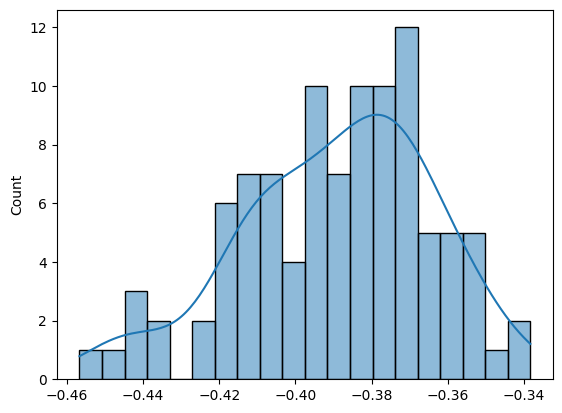

In [18]:

sns.histplot(
    ds.functional_connectivity[59334, :, 11, 0], bins=20, kde=True, stat="count"
)

In [21]:
from significantdigits import significant_digits

x = np.arctanh(ds.functional_connectivity[59334, :, 11, 0])
significant_digits(x, x.mean())

array(2.61097064)

In [29]:
x.mean()

<xarray.DataArray 'functional_connectivity' ()> Size: 8B
array(-0.41472443)
Coordinates:
    cell      <U76 304B '7Networks_RH_Cont_PFCl_5, 7Networks_RH_Cont_Temp_2'
    pipeline  <U10 40B 'TrueComb5'
    subject   <U9 36B 'sub-01'

In [20]:
x = ds.functional_connectivity[22805, :, 2, 0]
significant_digits(x, x.mean())

array(9.74880994)

In [22]:
x.mean().dtype

dtype('float64')

In [12]:
def make_sigdigs_vector(pipeline_index: int, subject_index: int = 0):
    #we need to feed x and the mean of x
    x = np.asarray(ds.functional_connectivity[:, :, pipeline_index, subject_index]).transpose()
    x.shape
    sigdigs = significant_digits(x, x.mean(axis=0), dtype=x.dtype, basis=10)
    sigdigs, sigdigs.shape
    invalid = np.isfinite(x).sum(axis=0) < 90
    sigdigs[invalid] = np.nan
    return sigdigs


def make_sigdigs_array(pipeline_index: int, subject_index: int = 0):
    array = np.full(fill_value=np.nan, shape=(k, k))
    array[*np.tril_indices(k, -1)] = make_sigdigs_vector(pipeline_index, subject_index)
    return array

def make_sigdigs_plot(title: str, ax: Axes, pipeline_index: int, subject_index: int = 0, cbar=True):
    array = make_sigdigs_array(pipeline_index, subject_index)
    sns.heatmap(array, vmax=4, vmin=-4, cmap="RdYlGn", ax=ax, cbar=cbar)  #"RdYlGn", cmap, vmax=4
    ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")

In [24]:
list(enumerate(pipelines))

[(0, 'FalseComb0'),
 (1, 'FalseComb1'),
 (2, 'FalseComb2'),
 (3, 'FalseComb3'),
 (4, 'FalseComb4'),
 (5, 'FalseComb5'),
 (6, 'TrueComb0'),
 (7, 'TrueComb1'),
 (8, 'TrueComb2'),
 (9, 'TrueComb3'),
 (10, 'TrueComb4'),
 (11, 'TrueComb5')]

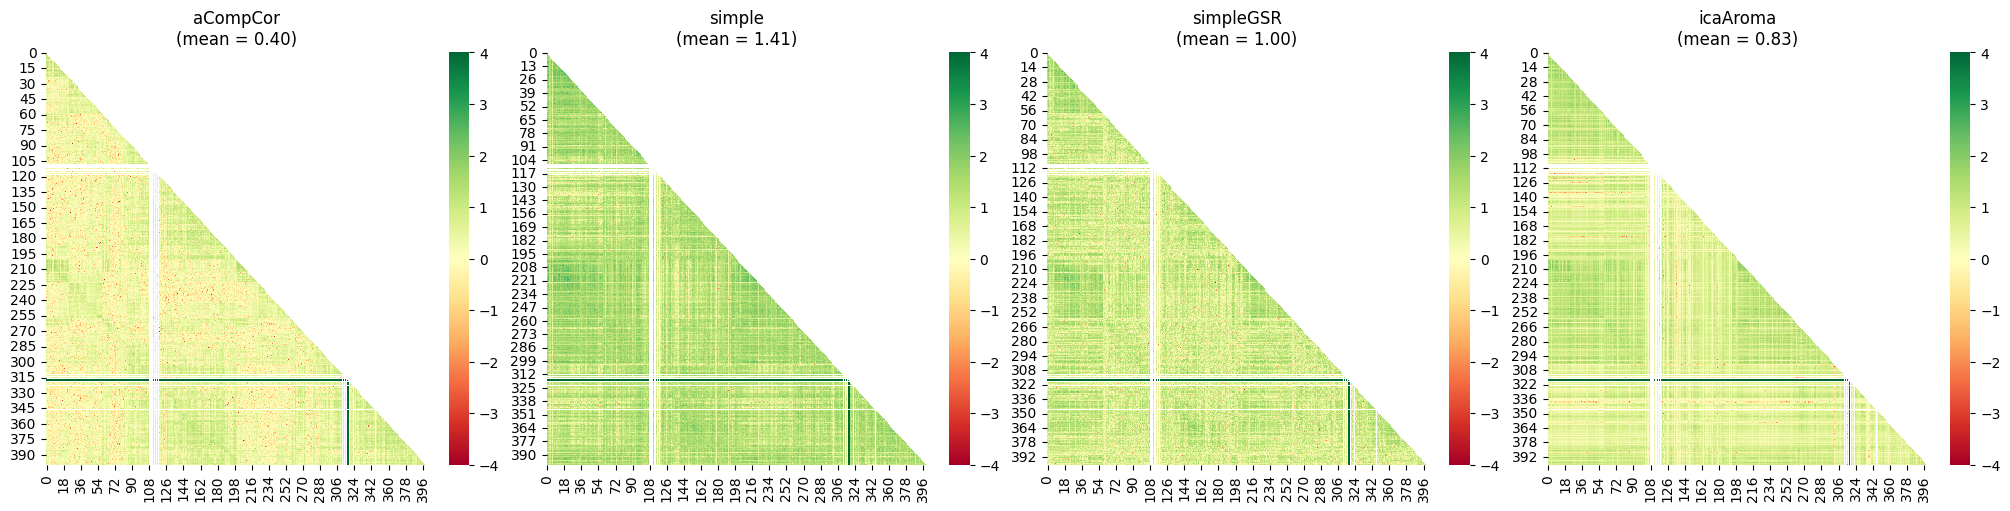

In [25]:

figure, axes_array = plt.subplots(
    ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True
)

subject_index = 1
make_sigdigs_plot("aCompCor", axes_array[0], 1, subject_index)
make_sigdigs_plot("simple", axes_array[1], 3, subject_index)
make_sigdigs_plot("simpleGSR", axes_array[2], 4, subject_index)
make_sigdigs_plot("icaAroma", axes_array[3], 6, subject_index)

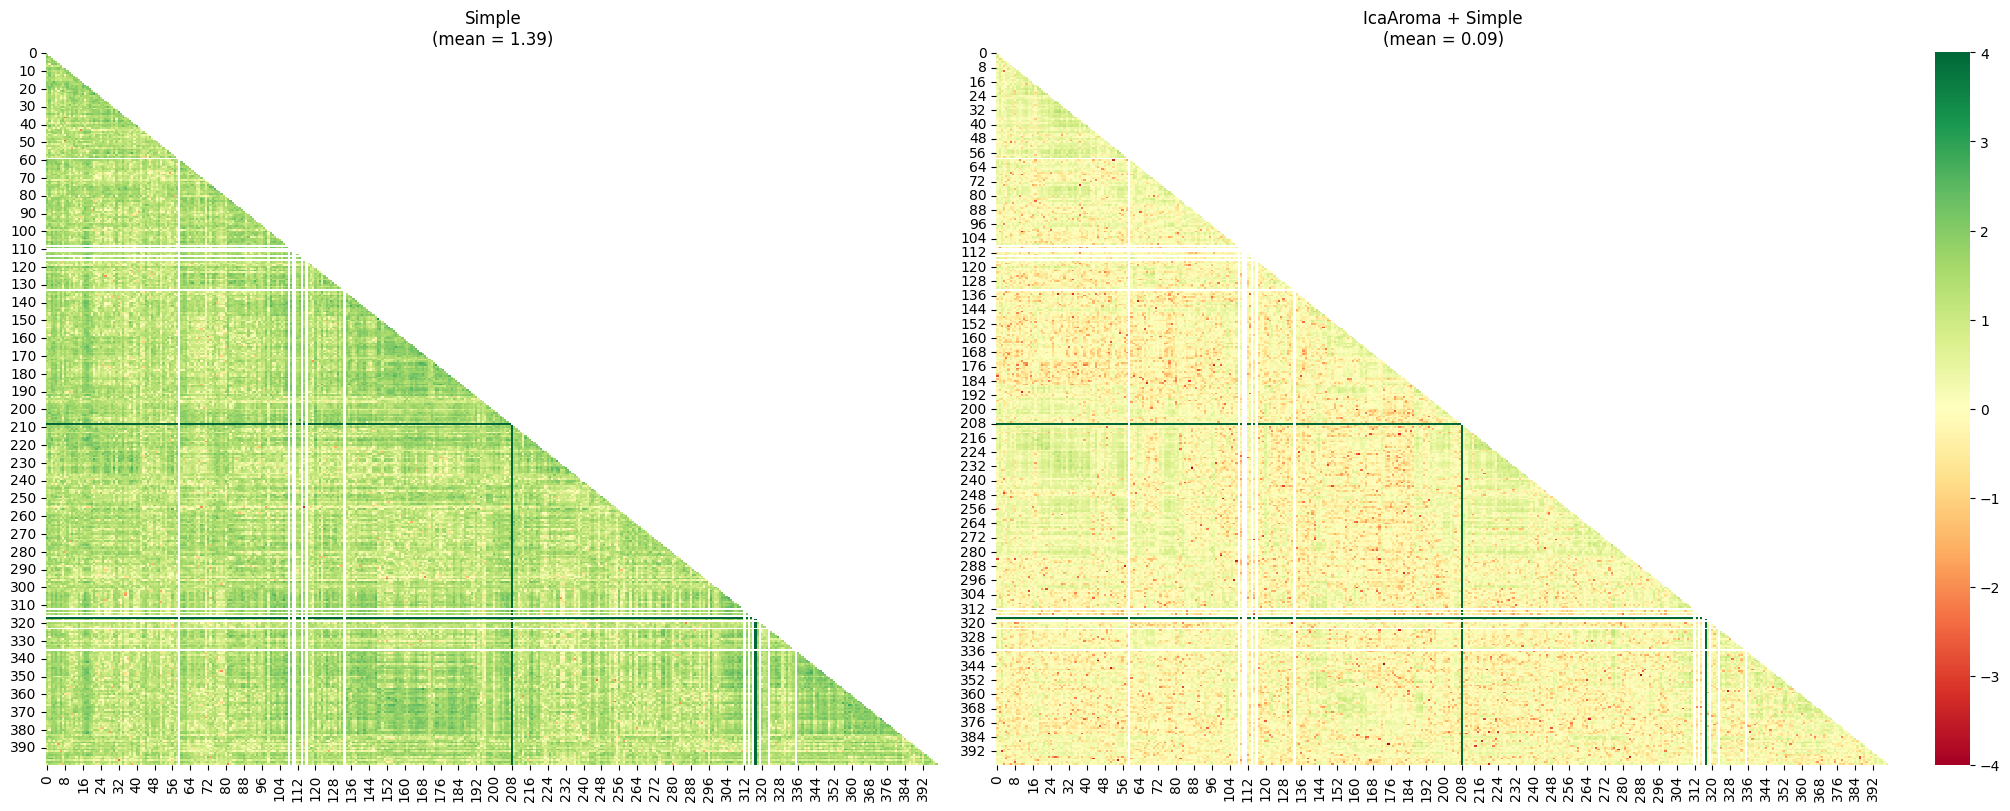

In [91]:

figure, axes_array = plt.subplots(
    ncols=2, sharex=True, figsize=(20, 8), constrained_layout=True
)

make_sigdigs_plot("Simple", axes_array[0], 3, subject_index, False)
make_sigdigs_plot("IcaAroma + Simple", axes_array[1], 9, subject_index, True)

In [70]:
# List of pipeline titles
pipeline_titles = [
    'FalseComb0', 'FalseComb1', 'FalseComb2', 'FalseComb3',
    'FalseComb4', 'FalseComb5', 'TrueComb0', 'TrueComb1',
    'TrueComb2', 'TrueComb3', 'TrueComb4', 'TrueComb5'
]

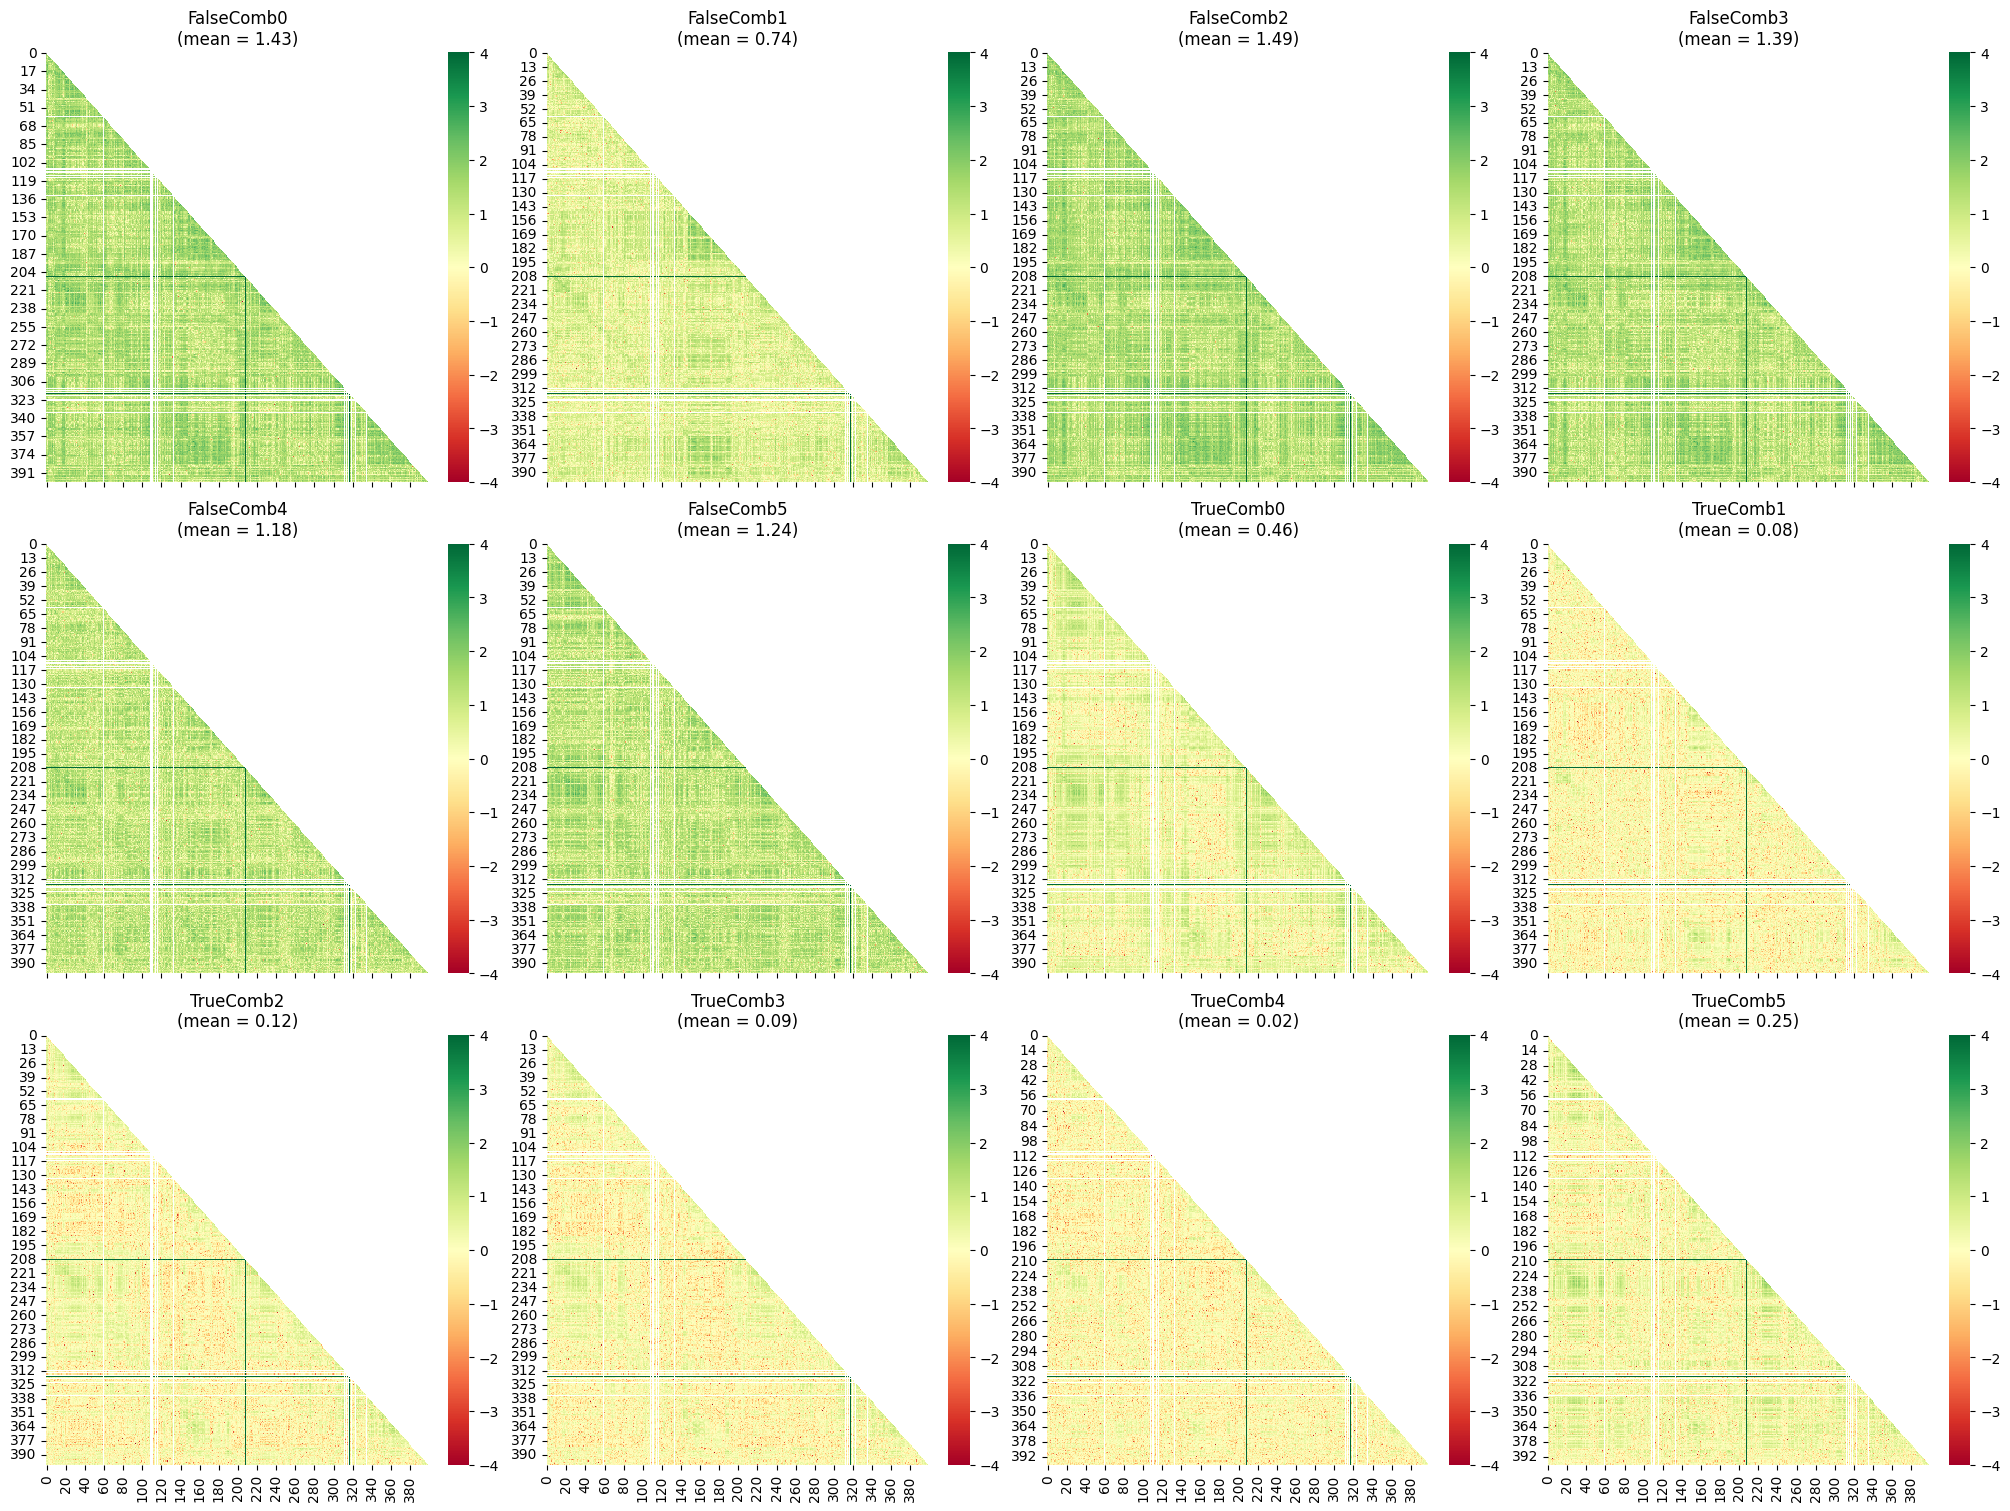

In [87]:
# Create subplots for 12 pipelines
fig, axes_array = plt.subplots(
    nrows=3, ncols=4, sharex=True, figsize=(20, 15), constrained_layout=True
)

axes_array = axes_array.flatten() #

for i, (title, ax) in enumerate(zip(pipeline_titles, axes_array)):
    make_sigdigs_plot(title, ax, i, subject_index, True)

plt.show()

In [23]:
import scipy.stats

scipy.stats.ttest_rel(make_sigdigs_vector(1), make_sigdigs_vector(6), nan_policy="omit")

TtestResult(statistic=nan, pvalue=nan, df=nan)

In [22]:
import numpy.ma as ma

a, b = make_sigdigs_vector(1, 1), make_sigdigs_vector(6, 1)
ma.corrcoef(ma.masked_invalid(a), ma.masked_invalid(b))

masked_array(
  data=[[--, --],
        [--, --]],
  mask=[[ True,  True],
        [ True,  True]],
  fill_value=1e+20,
  dtype=float64)

(-2.0, 3.0)

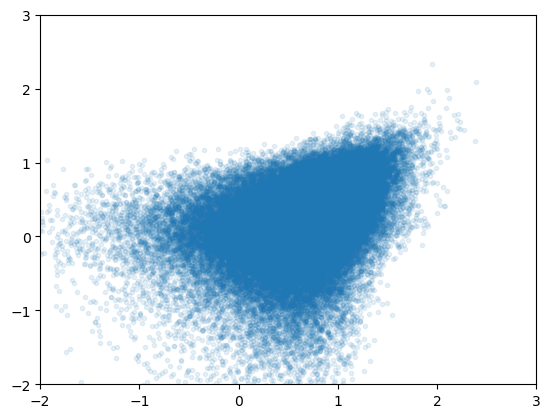

In [181]:
plt.plot(make_sigdigs_vector(1), make_sigdigs_vector(6), ".", alpha=0.1)
plt.ylim(-2, 3)
plt.xlim(-2, 3)

In [169]:
np.nanmean(make_signdigs_array(1)), np.nanmean(make_signdigs_array(6))

(np.float64(0.7506430485664511), np.float64(0.3567614650303614))

In [13]:
# ds.to_netcdf(
#     "/lea/downloads/saved_on_disk.h5",
#     engine="h5netcdf",
#     encoding=dict(
#         functional_connectivity=dict(
#             compression="gzip", compression_opts=9, shuffle=True
#         )
#     ),
# )

In [28]:
mean = ds.functional_connectivity.mean(axis=(1))

In [29]:
ds.functional_connectivity[:, :, 0, 0].shape, mean[:, 0, 0, np.newaxis].shape

IndexError: too many indices

In [30]:


xr.corr(ds.functional_connectivity[:, :, 0, 0], mean[:, 0, 0], dim="cell")



<xarray.DataArray 'functional_connectivity' (iteration: 100)> Size: 800B
array([0.99984655, 0.99987761, 0.9992189 , 0.99955602, 0.99953035,
       0.99975706, 0.99909229, 0.99884525, 0.99981434, 0.99983853,
       0.99973357, 0.99985505, 0.99984802, 0.99984108, 0.99933392,
       0.99927232, 0.99988343, 0.99985986, 0.99969839, 0.99932996,
       0.99986772, 0.99949373, 0.99905983, 0.99943598, 0.99983092,
       0.99989437, 0.99962966, 0.99922913, 0.99946755, 0.99942358,
       0.99954067, 0.99927387, 0.99987285, 0.99979719, 0.9997493 ,
       0.99953942, 0.99983862, 0.99956462, 0.9993505 , 0.99959246,
       0.99993789, 0.99957946, 0.99986228, 0.99949502, 0.99973796,
       0.99972802, 0.99945272, 0.99959412, 0.99943525, 0.99974502,
       0.99943828, 0.99983697, 0.99986677, 0.9992939 , 0.99988162,
       0.99938832, 0.99945572, 0.99970443, 0.99976876, 0.99949604,
       0.99974152, 0.99862384, 0.99985736, 0.99983304, 0.99949165,
       0.99879454, 0.99956608, 0.9998794 , 0.99929494, 0.99948468,
       0.99992345, 0.99981492, 0.99987666, 0.99961309, 0.99915973,
       0.99989199, 0.99910403, 0.99984492, 0.99977805, 0.99964911,
       0.99977046, 0.99954059, 0.99951531, 0.99941309, 0.99945625,
       0.99979064, 0.99962241, 0.99877417, 0.99956219, 0.99912679,
       0.99977252, 0.9994423 , 0.99989983, 0.99936202, 0.9994525 ,
       0.99976269, 0.99931247, 0.9996405 , 0.99986367, 0.99988461])
Coordinates:
  * iteration  (iteration) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    pipeline   <U10 40B 'FalseComb0'
    subject    <U9 36B 'sub-01'

In [ ]:
np.corrcoef(ds.functional_connectivity[:, :, 0, 0]).shape

### Seed connectivity

In [14]:
seed = np.load('data/sub-9040_seed.npz')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/2210946125.py:10: RuntimeWarning: Mean of empty slice
  gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/2210946125.py:12: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/2210946125.py:14: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/signific

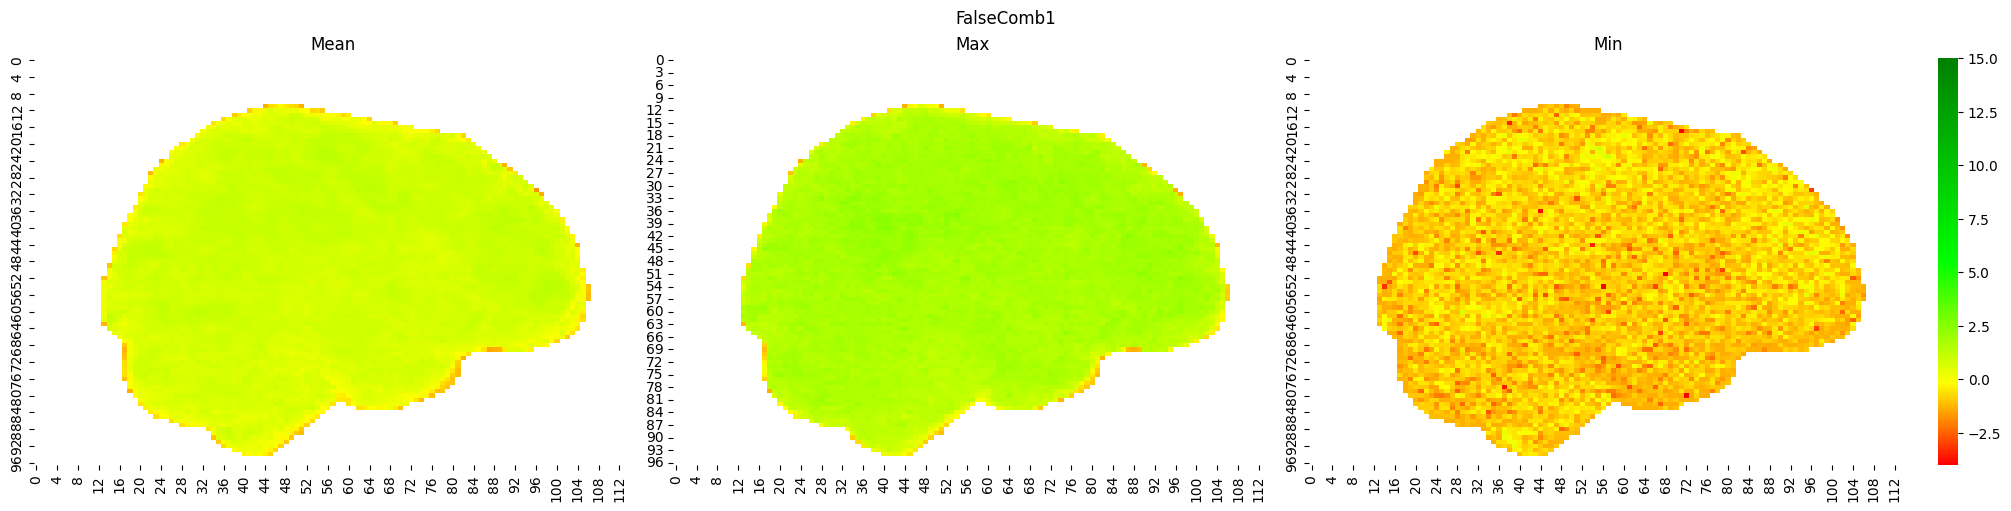

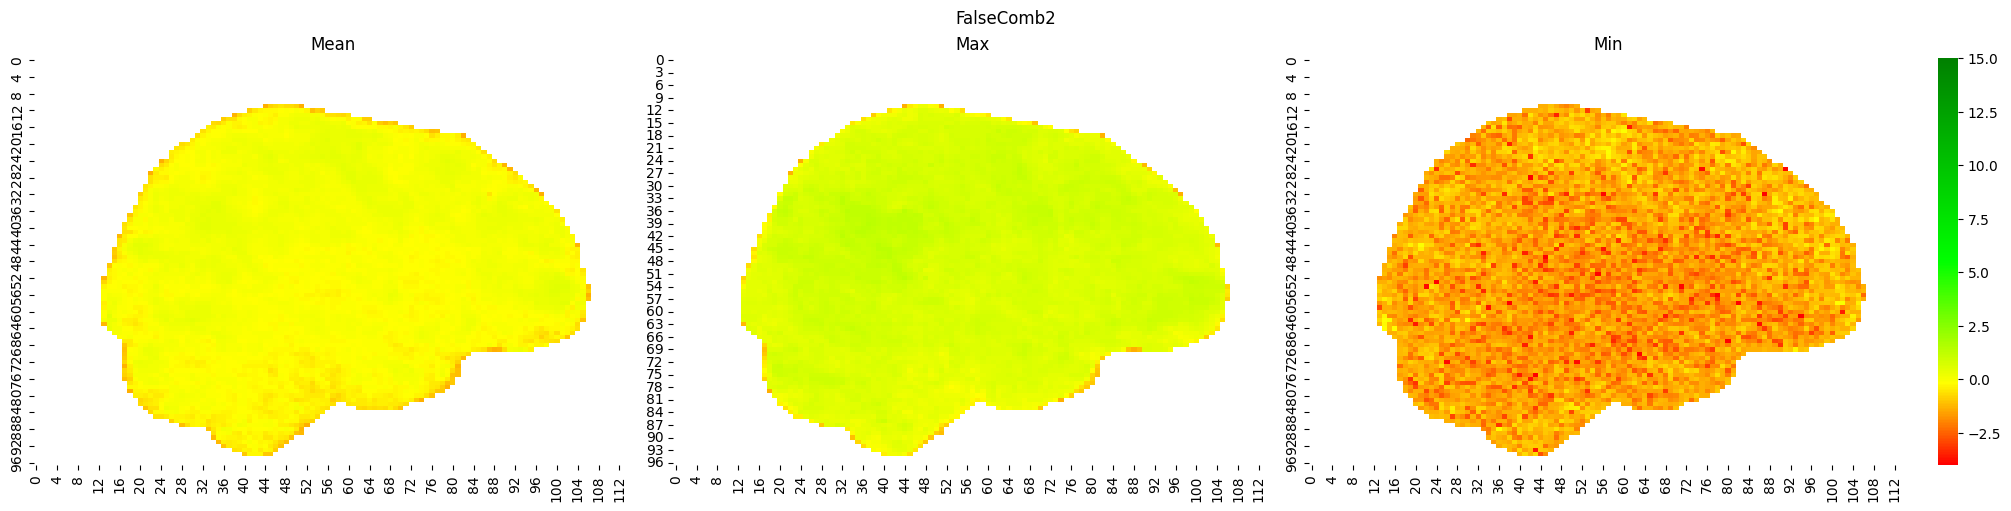

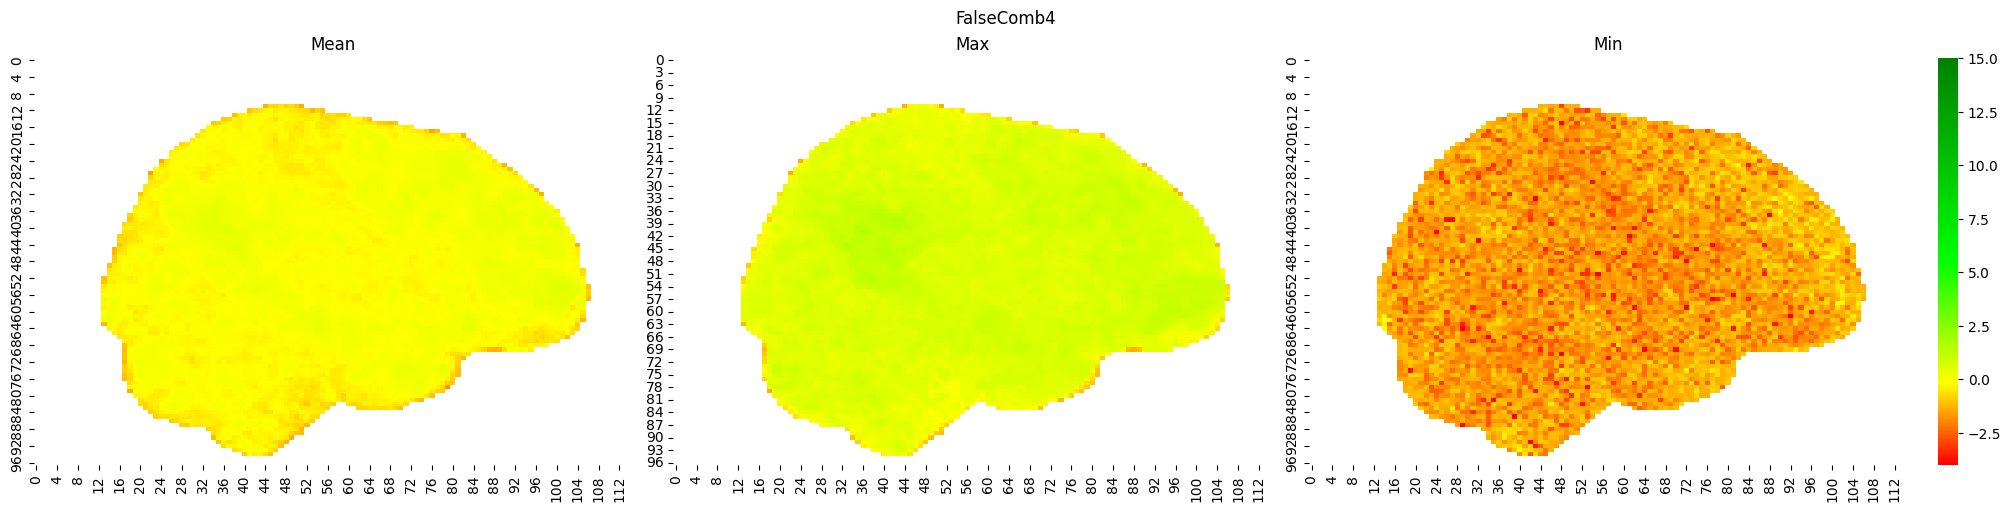

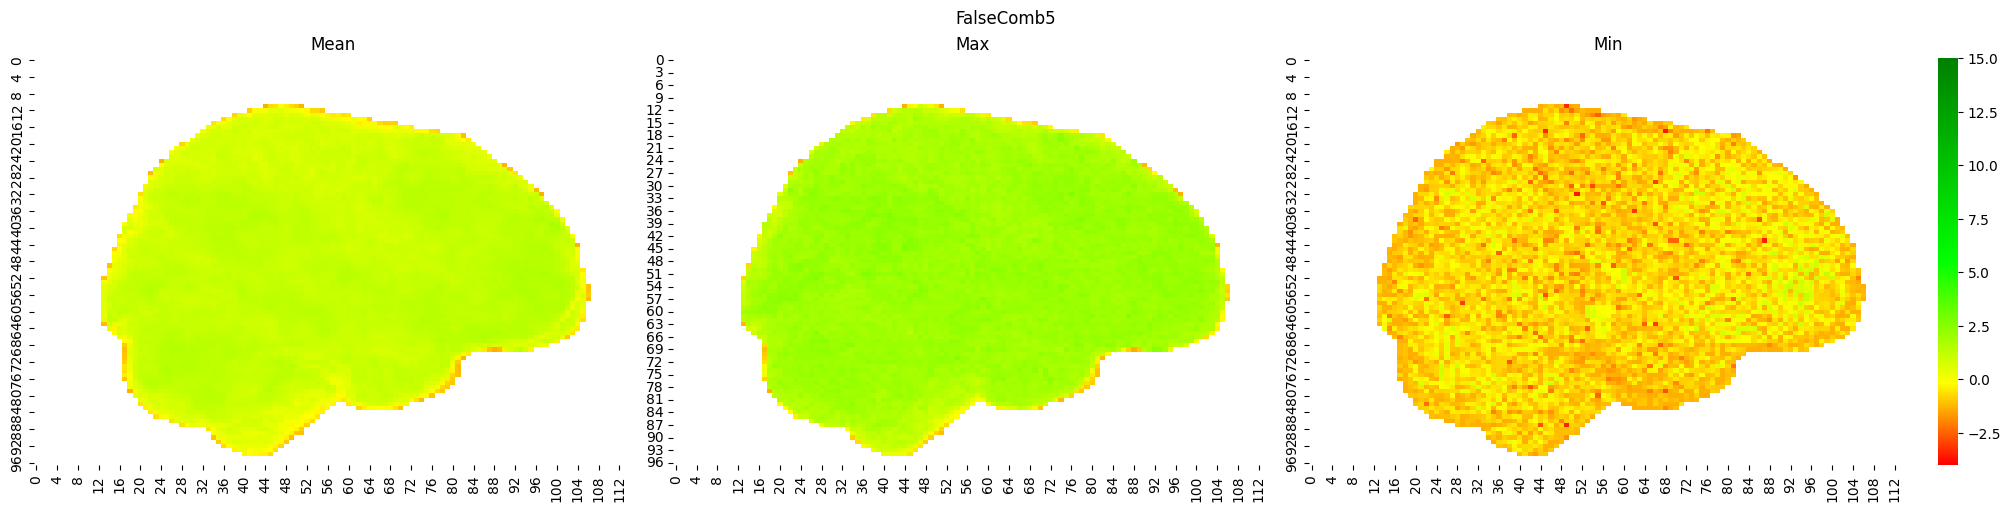

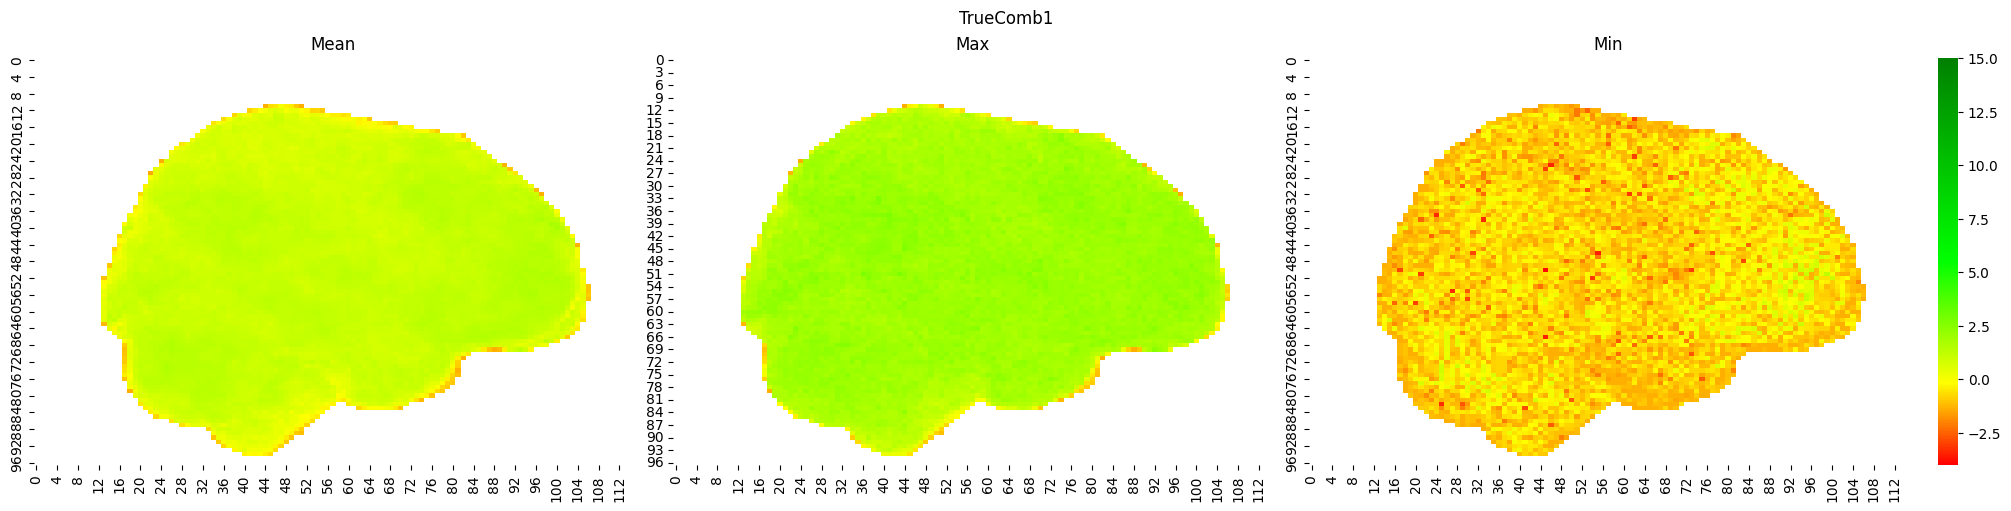

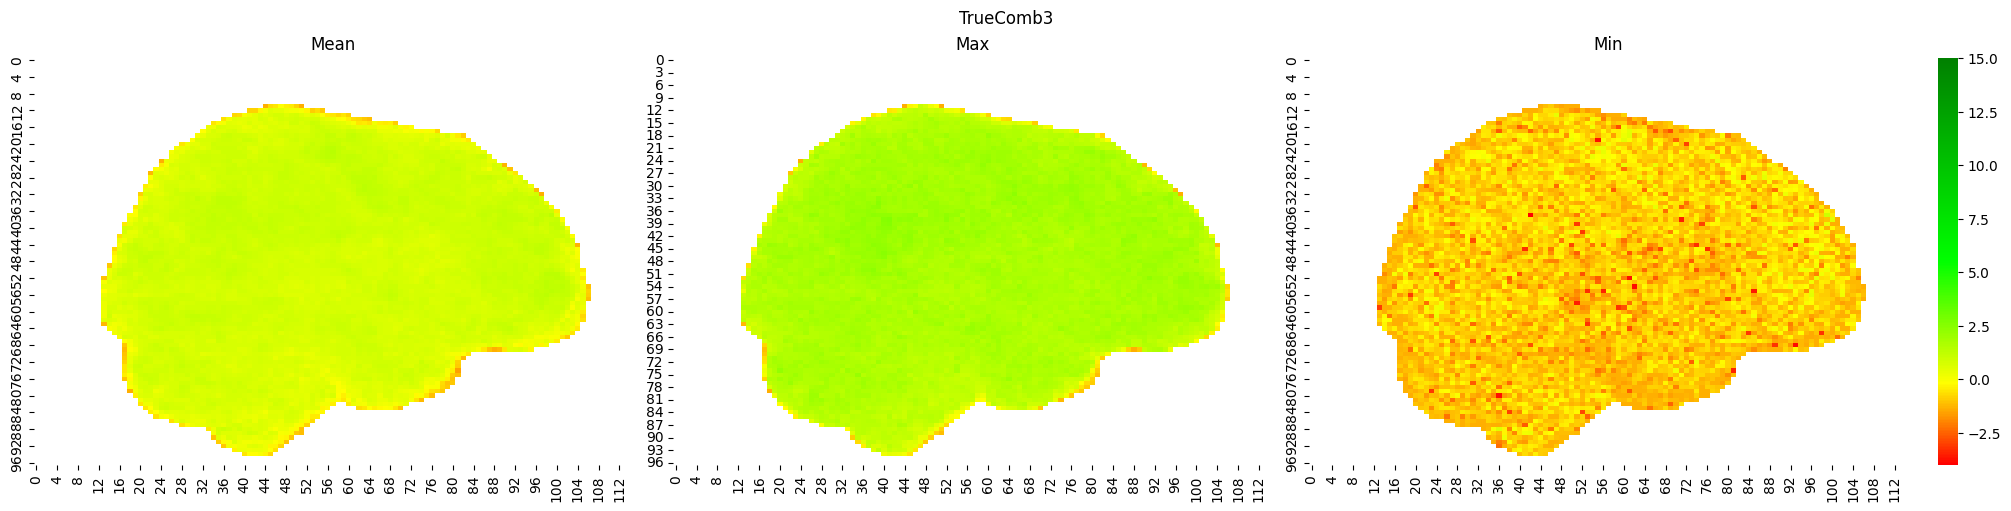

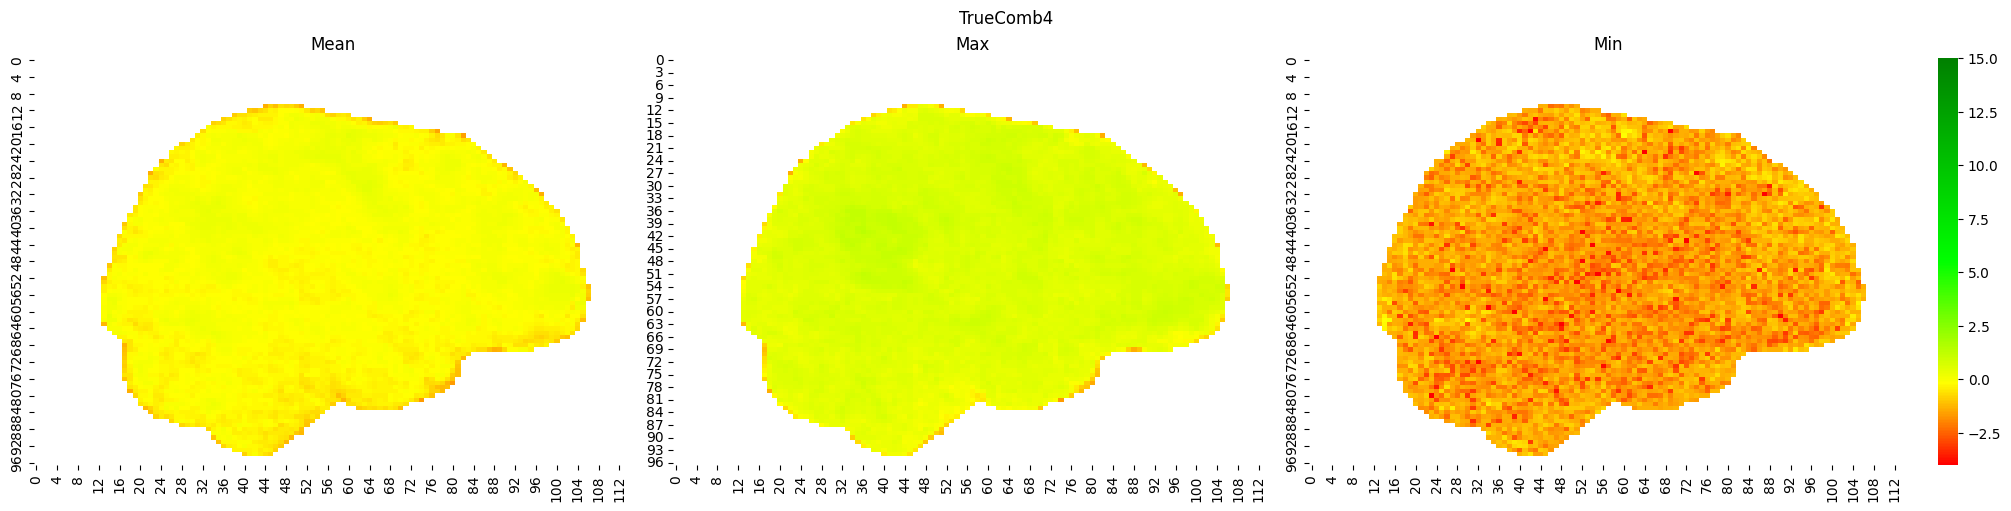

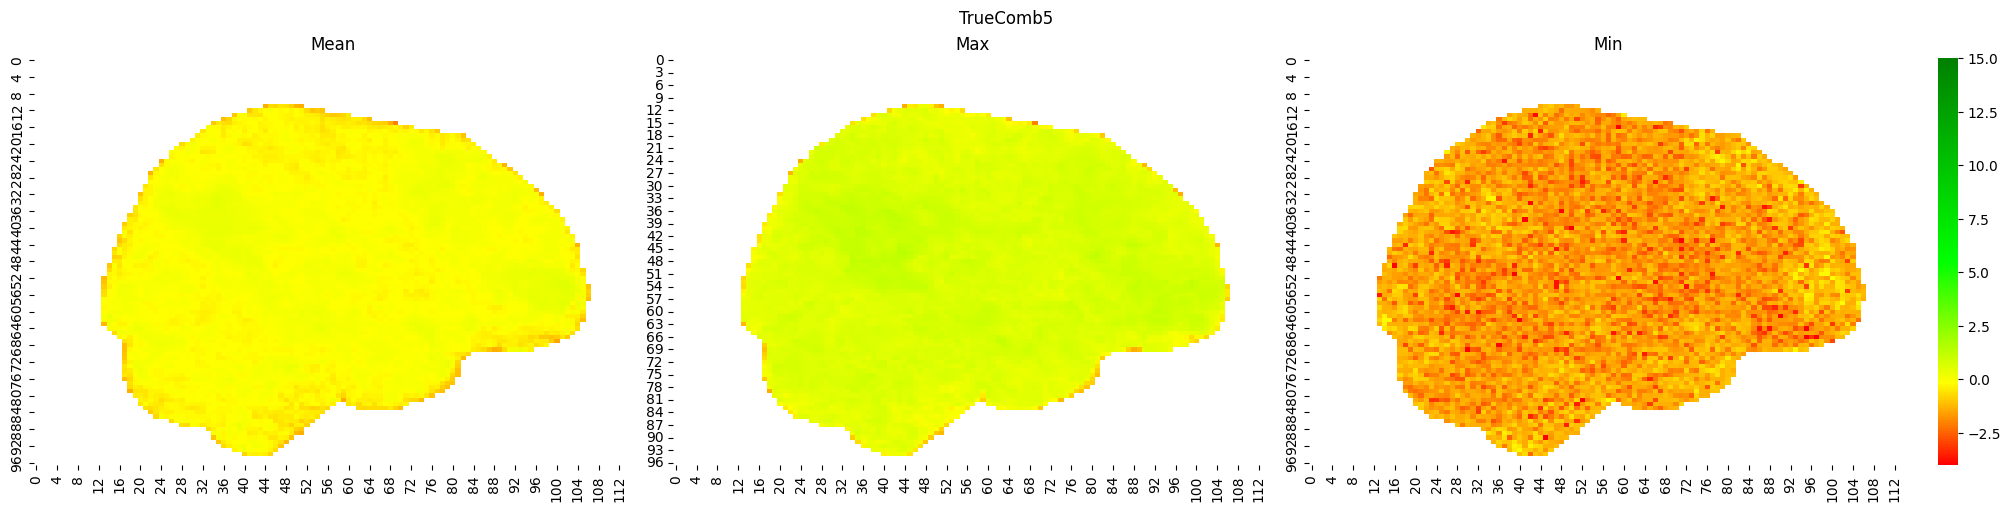

In [15]:
colors = ['Red', 'yellow', 'lime', 'green']
values = np.array([0, 0.2, 0.5, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))

for num,  pre_process in list(enumerate(pipelines)):
    sigdigs = sd.significant_digits(seed['arr_0'][num], reference=seed['arr_0'][num].mean(axis=0), basis=10)
    sigdigs[sigdigs >= 15] = np.nan
    fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(20,5), constrained_layout=True)

    gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
    gc.set_title('Mean')
    gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
    gc.set_title('Max')
    gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
    gc.set_title('Min')
    plt.suptitle(pre_process)
    # break


/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/3771921850.py:3: RuntimeWarning: Mean of empty slice
  gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/3771921850.py:5: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/3771921850.py:7: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)


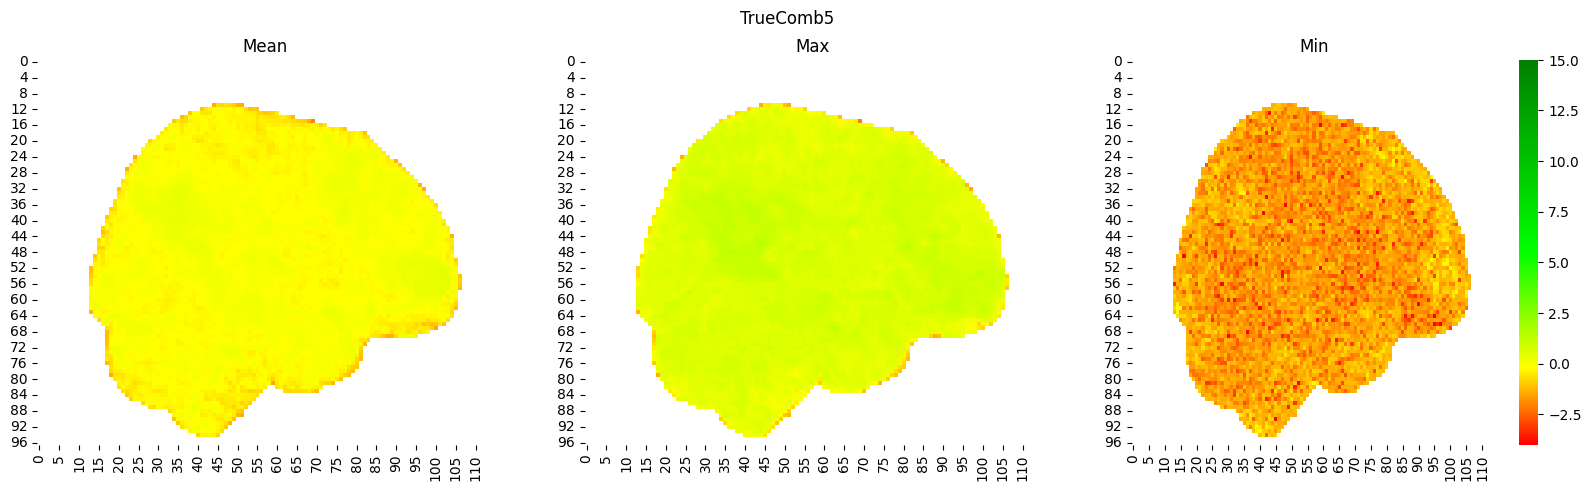

In [16]:
fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(20,5), )

gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
gc.set_title('Mean')
gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
gc.set_title('Max')
gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
gc.set_title('Min')
plt.suptitle(pre_process);

### Split paired distribution test

#### Idea

For each subject and pipeline we have ~100 iterations. In the following block we create a test that compares the distribution of the cell values for 70 of those iterations versus the resting 30. The test compares between these distributions with an independent t-test. The test is done for each cell per pipeline and subject, so it takes a bit of time. 

At the end, we plot the results of the tests. We want to plot the p-values in the place of the cells, where non-significant cells are transparent (i.e. masked) and significant cells (starting at 95% confidence) are plotted with a gradient, with stronger colors for more significant. 

#### Previous approaches


Both the Mann-Whitney and the Kolmogorov-Smirnov tests are nonparametric tests to compare two unpaired groups of data. Both compute P values that test the null hypothesis that the two groups have the same distribution. But they work very differently:

•The **Mann-Whitney test** first ranks all the values from low to high, and then computes a P value that depends on the discrepancy between the mean ranks of the two groups.

•The Kolmogorov-Smirnov test compares the cumulative distribution of the two data sets, and computes a P value that depends on the largest discrepancy between distributions.

**1. Interpreting the P value of KS test**. The P value is the answer to this question:

`"If the two samples were randomly sampled from identical populations, what is the probability that the two cumulative frequency distributions would be as far apart as observed? More precisely, what is the chance that the value of the Komogorov-Smirnov D statistic would be as large or larger than observed?"`
    
    If the P value is small, conclude that the two groups were sampled from populations with different distributions**. The populations may differ in median, variability or the shape of the distribution.


**2. Interpreting the P value of MWU test**. The P value is the answer to this question:

`"If the groups are sampled from populations with identical distributions, what is the chance that random sampling would result in the mean ranks being as far apart (or more so) as observed in this experiment?"`
    
    If the P value is small, you can reject the null hypothesis that the difference is due to random sampling, and conclude instead that the populations are distinct..


Reference: https://www.graphpad.com/guides/prism/latest/statistics/interpreting_results_kolmogorov-smirnov_test.htm





In [13]:
iterations = ds.iteration.values
np.random.seed(0)  # For reproducibility
np.random.shuffle(iterations)
group1 = iterations[:70]
group2 = iterations[70:]
group1, group2

(array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
        24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
        51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
        59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
        14, 89]),
 array([19, 29, 49, 97, 98, 69, 20, 94, 72, 77, 25, 37, 81, 46, 39, 65, 58,
        12, 88, 70, 87, 36, 21, 83,  9, 96, 67, 64, 47, 44]))

In [22]:
p_values = np.zeros(ds.functional_connectivity.shape[0])
p_values.shape

(79800,)

In [86]:
calculate_p_values(1,1)

data shape 1  (70,)
data shape 2  (30,)


array([0.78945147, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [109]:
def calculate_p_values(pipeline_index: int, subject_index: int):
    '''
    Define the split of the data correctly (!) Here we are comparing 70 iterations vs. 30
    '''
    
    iterations = ds.iteration.values
    np.random.seed(0)  # For reproducibility
    np.random.shuffle(iterations)
    group1 = iterations[:70]
    group2 = iterations[70:]

    p_values = np.zeros(ds.functional_connectivity.shape[0]) # Create array of 0s to store p-values
    
    for i in range(ds.functional_connectivity.shape[0]): # for each cell in 79800
        data_group1 = ds.functional_connectivity[i, group1, pipeline_index, subject_index]
        data_group2 = ds.functional_connectivity[i, group2, pipeline_index, subject_index]
        #print("data shape 1 ",data_group1.shape)
        #print("data shape 2 ",data_group2.shape)
        #_, p_value = scipy.stats.ks_2samp(data_group1, data_group2)  #KS test
        #_, p_value = scipy.stats.mannwhitneyu(data_group1, data_group2) 
        _, p_value = scipy.stats.ttest_ind(data_group1, data_group2, equal_var=True) 
            #non parametric version of Independent t_test ?  
        #_, p_value = ttest_rel(data_group1, data_group2) # Perform paired t-test. But this does not make sense 

        p_values[i] = p_value

    return p_values

def make_p_values_array(pipeline_index: int, subject_index: int):
    p_values = calculate_p_values(pipeline_index, subject_index)
    array = np.full(fill_value=np.nan, shape=(k, k))
    array[*np.tril_indices(k, -1)] = p_values
    return array 
    
def plot_p_values(title: str, ax, pipeline_index: int, subject_index: int):
    array = make_p_values_array(pipeline_index, subject_index)
    significance_level = 0.05
    significant_mask = array < significance_level
    mask = np.isnan(array) | ~significant_mask    # Create a mask for non-significant values
    
    sns.heatmap(array, mask=mask, cmap="viridis_r", cbar=True, ax=ax)

    # Calculate the percentage of significant cells
    total_cells = np.sum(~np.isnan(array))
    significant_cells = np.sum(significant_mask)
    percentage_significant = (significant_cells / total_cells) * 100
    
    ax.set_title(f"{title}\n(Significant percentage (Diff distributions) = {percentage_significant:.2f} % )")

def extract_significant_indices(p_values, threshold=0.01):
    significant_indices = np.where(p_values < threshold)[0]
   # significant_indices = np.where(np.isfinite(p_values) & (p_values < threshold))[0]
    if len(significant_indices) == 0:
        raise ValueError("No significant cells found")
    return significant_indices

def compare_2distributions(cell_index, pipeline_index, subject_index, p_value):
    iterations = ds.iteration.values
    group1 = iterations[:70]
    group2 = iterations[70:]

    data_group1 = ds.functional_connectivity[cell_index, group1, pipeline_index, subject_index]
    data_group2 = ds.functional_connectivity[cell_index, group2, pipeline_index, subject_index]
    print(data_group1)
    print(data_group2)

    
    plt.figure(figsize=(10, 6))
    sns.histplot(data_group1, bins=20, kde=True, stat="count", color='blue', label='Group 1 (70 iterations)')
    sns.histplot(data_group2, bins=20, kde=True, stat="count", color='orange', label='Group 2 (30 iterations)')
    plt.title(f'Distributions for Cell {cell_index} in pipeline {pipelines[pipeline_index]}, {subjects[subject_index]}, (p-value: {p_value:.4e})') 
    plt.legend()
    plt.show()

In [79]:
pipelines

array(['FalseComb0', 'FalseComb1', 'FalseComb2', 'FalseComb3',
       'FalseComb4', 'FalseComb5', 'TrueComb0', 'TrueComb1', 'TrueComb2',
       'TrueComb3', 'TrueComb4', 'TrueComb5'], dtype='<U10')

In [80]:
# Plotting for one subject and one pipeline
pipeline_index = 5
subject_index = 1

p_values = calculate_p_values(pipeline_index, subject_index)
significant_cells_indices = extract_significant_indices(p_values, threshold=0.01)
print(f"Significant cells indices: {significant_cells_indices}")


Significant cells indices: [  811  2091  2092  2136  4732  5081  6860  7411  7743  8721  8744  8780
  8821  8901  8905  9448 10079 10732 10742 10744 10749 10755 10756 10758
 10759 10779 10781 10783 10787 10789 10795 10806 10828 10855 11273 12252
 12284 12330 12344 12352 12353 12377 12386 12388 12389 12392 12393 12396
 15332 15372 15382 16108 19062 19257 20057 20257 20636 22431 23018 23367
 23800 23936 24018 24375 24910 25670 25672 27175 27203 27215 27359 27997
 28113 28730 29550 29793 29833 29886 29988 30002 30117 30200 30282 31006
 31008 31352 31516 36203 40407 40617 40716 41765 42342 42551 42618 42927
 42935 43221 43228 43419 43434 43447 43489 43512 43589 43684 43688 43690
 43692 43693 43698 43700 43702 43742 43743 43755 43757 43760 43765 43784
 43785 43787 43790 43796 43797 43799 43806 43807 43821 43825 43835 43841
 43868 43875 43877 43878 43887 43893 43906 43908 43922 43942 44549 44698
 46151 46192 46301 46352 46517 46782 46961 46982 47054 47106 47128 47183
 47215 47266 47435 47573

<xarray.DataArray 'functional_connectivity' (iteration: 70)> Size: 560B
array([-0.43373442, -0.43138773, -0.43038723, -0.43087066, -0.43547251,
       -0.43708443, -0.43547741, -0.43103609, -0.43153585, -0.43572087,
       -0.42991489, -0.42645576, -0.43290375, -0.43243458, -0.4295786 ,
       -0.43214422, -0.43627484, -0.43118678, -0.43386367, -0.43827596,
       -0.43320945, -0.43202366, -0.43604972, -0.43092587, -0.43446689,
       -0.43500582, -0.43443624, -0.43297183, -0.43367756, -0.43319766,
       -0.43221871, -0.43167755, -0.43591544, -0.43146739, -0.4276142 ,
       -0.43419058, -0.4320323 , -0.43087047, -0.43136305, -0.43258651,
       -0.42842594, -0.43644681, -0.43039076, -0.43353657, -0.43418726,
       -0.43319856, -0.43776677, -0.43502684, -0.43018119, -0.43011267,
       -0.43352561, -0.43198041, -0.43116508, -0.43300787, -0.43121349,
       -0.43699993, -0.4342611 , -0.43502333, -0.42969286, -0.43765454,
       -0.43419127, -0.43367875, -0.43361104, -0.43069193, -0.43

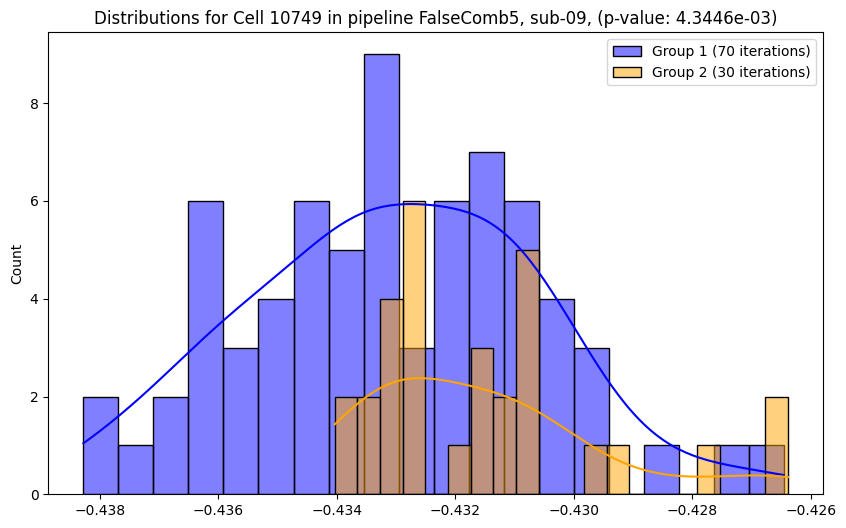

0.004344627927717672


In [112]:
select=20

cell_index = significant_cells_indices[select]  
p_value = p_values[cell_index]
compare_2distributions(cell_index, pipeline_index, subject_index, p_value)
print(p_value)

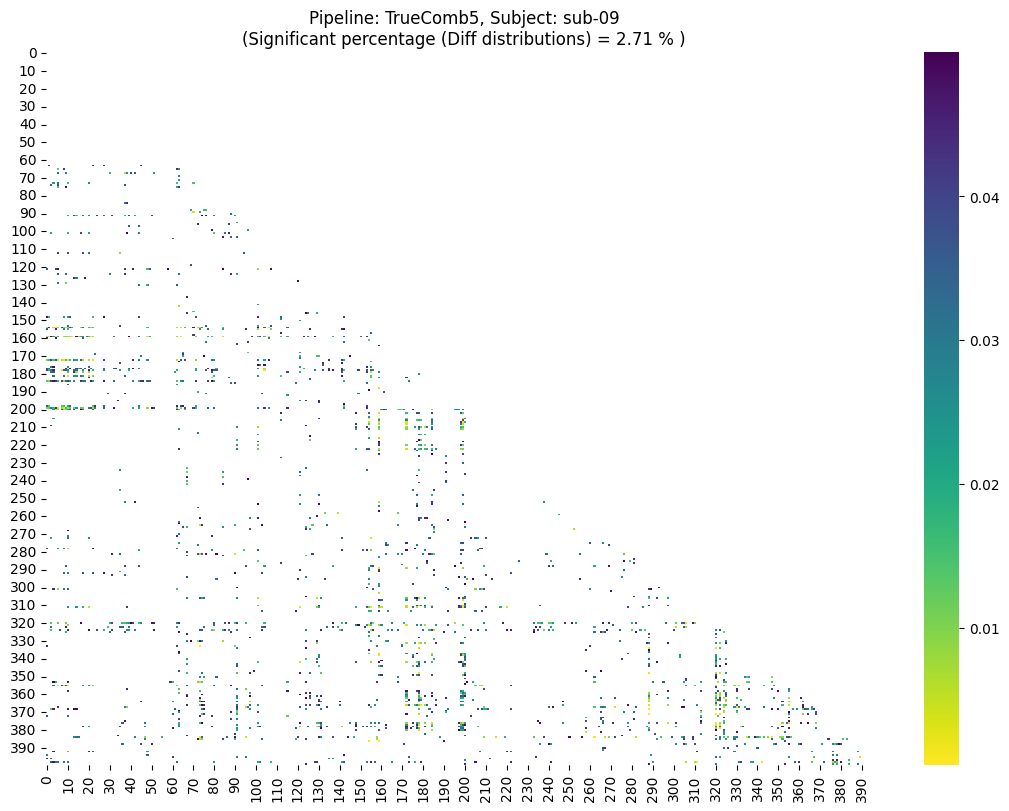

In [27]:
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
plot_p_values(f"Pipeline: {pipelines[pipeline_index]}, Subject: {subjects[subject_index]}", ax, pipeline_index, subject_index)
plt.show()

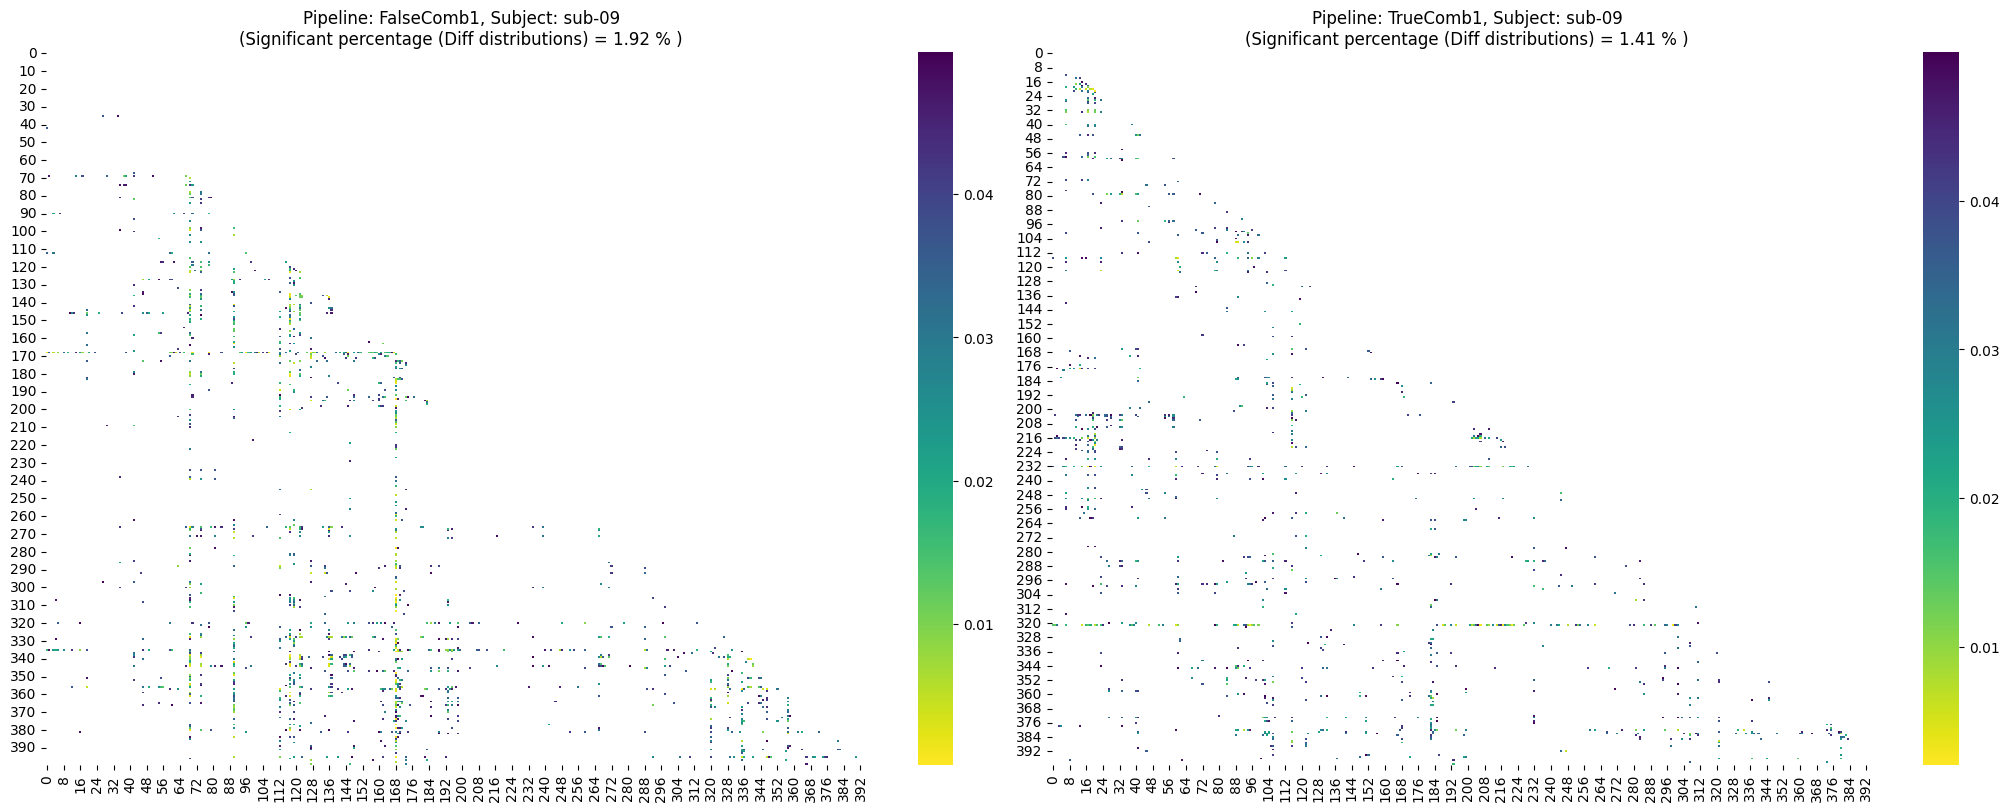

In [28]:
figure, axes_array = plt.subplots(ncols=2, sharex=True, figsize=(20, 8), constrained_layout=True)

plot_p_values(f"Pipeline: {pipelines[1]}, Subject: {subjects[subject_index]}", axes_array[0], 1, subject_index)
plot_p_values(f"Pipeline: {pipelines[7]}, Subject: {subjects[subject_index]}", axes_array[1], 7, subject_index)

In [56]:
subjects = ds.subject.values
pipelines = ds.pipeline.values
subjects[:2]

array(['sub-01', 'sub-09'], dtype='<U9')

KeyboardInterrupt: 

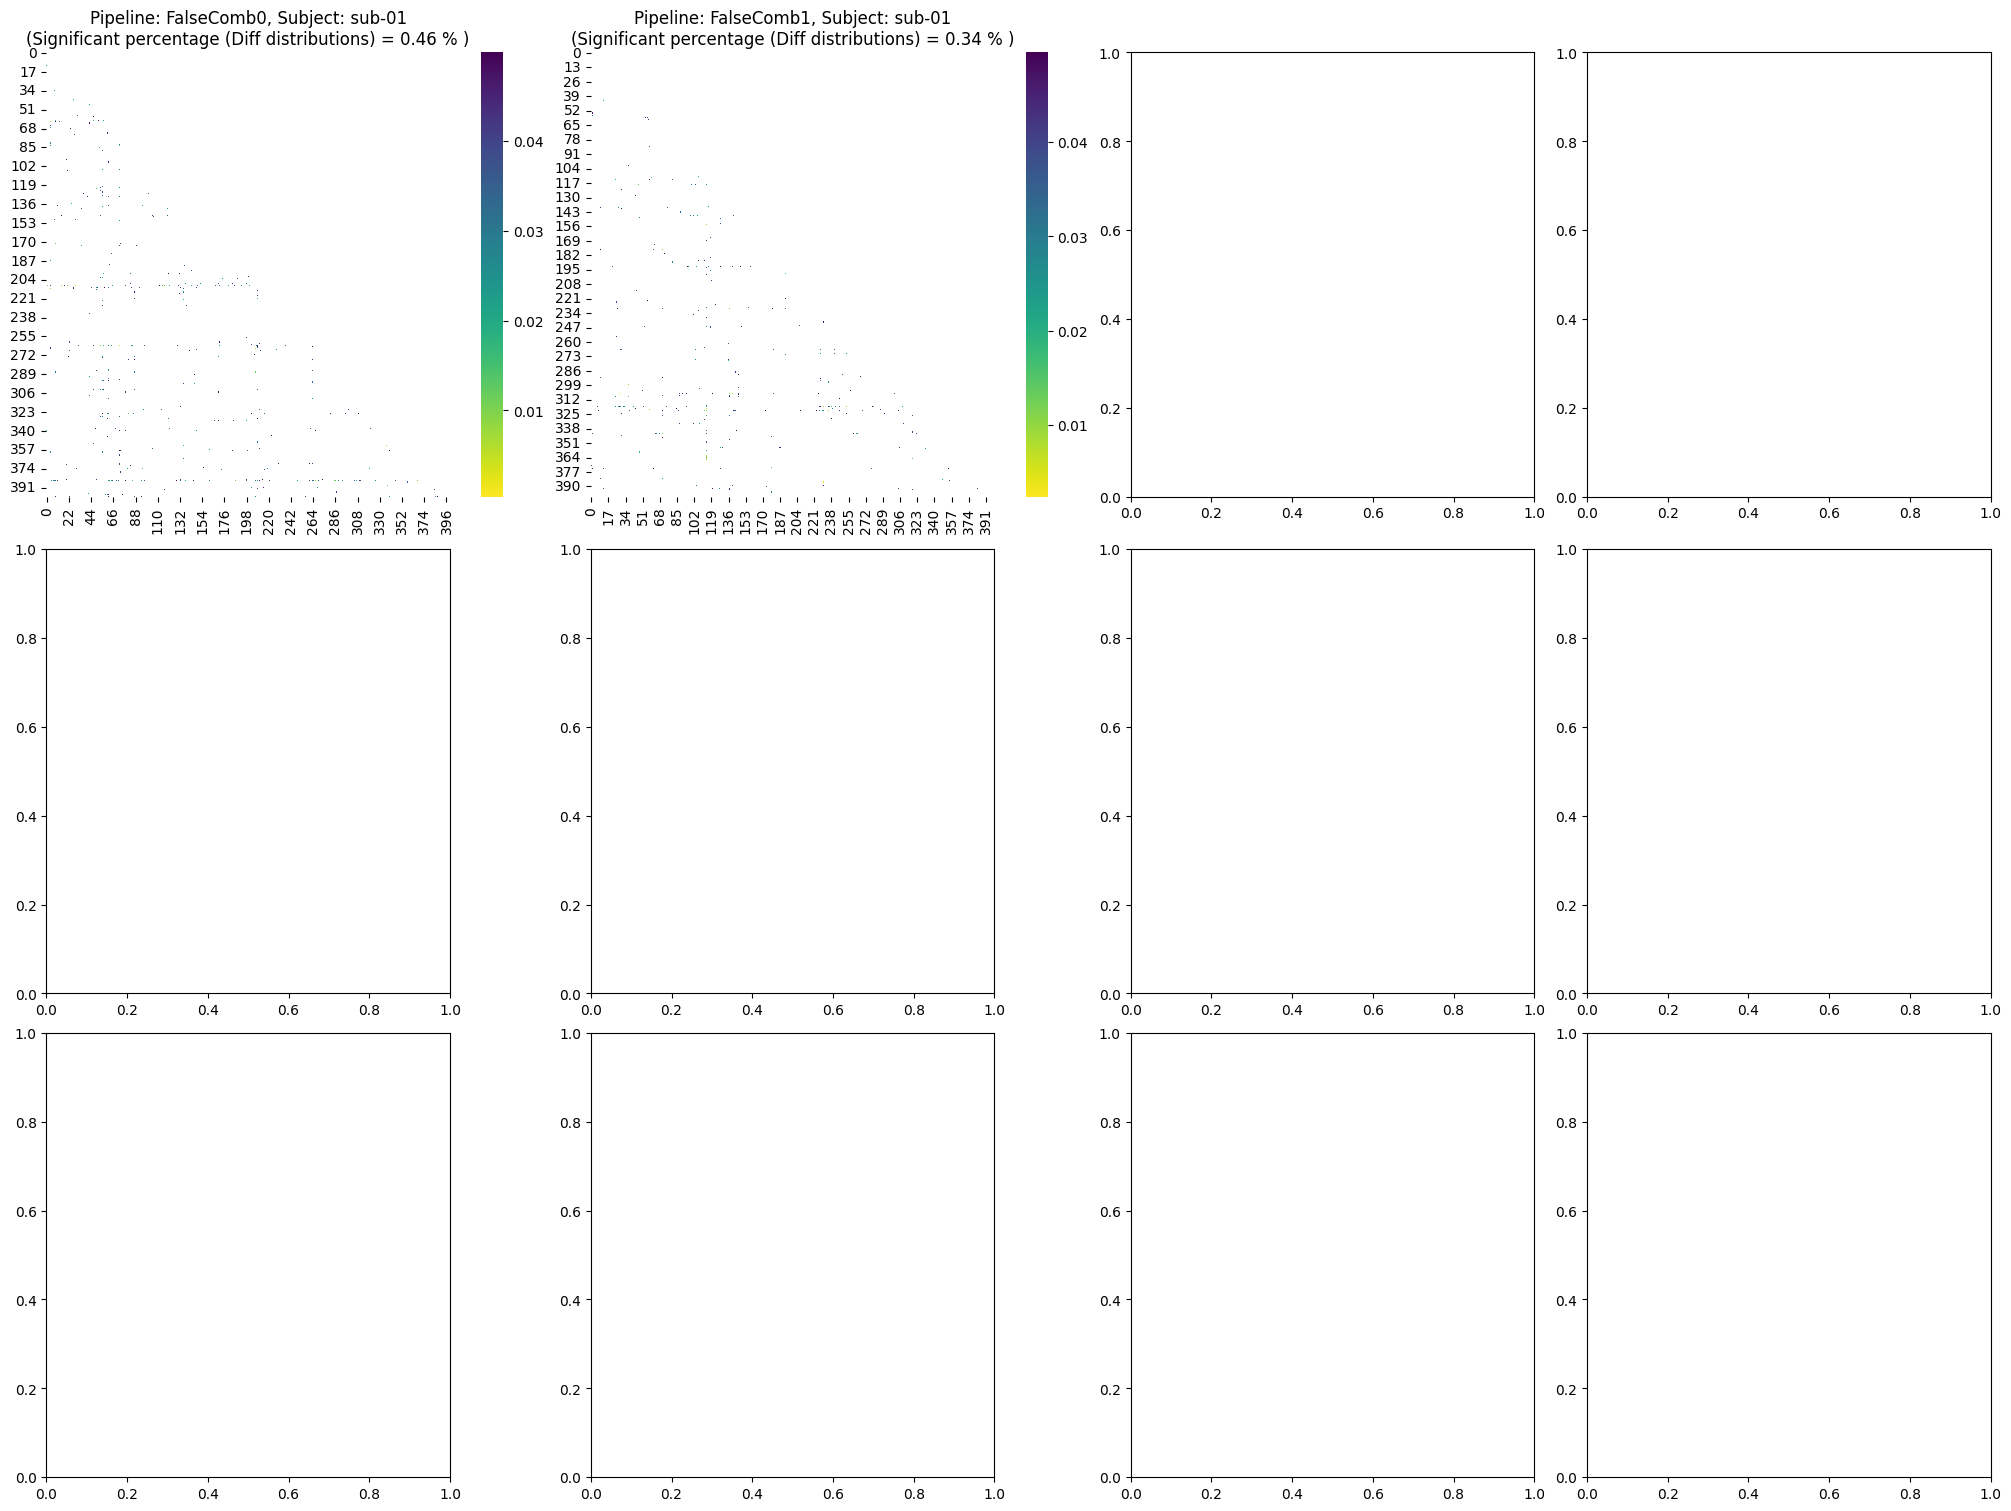

In [113]:
subjects = ds.subject.values
pipelines = ds.pipeline.values

for subject_index in range(len(subjects[:2])):
    subject = subjects[subject_index]
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), constrained_layout=True)
    
    for pipeline_index in range(len(pipelines)):
        pipeline = pipelines[pipeline_index]
        ax = axes[pipeline_index // 4, pipeline_index % 4]
        plot_p_values(f"Pipeline: {pipeline}, Subject: {subject}", ax, pipeline_index, subject_index)
    
    plt.suptitle(f"P-values for Subject: {subject}", fontsize=16)
    plt.show()